Reference:
1. Encode categorical variables: http://pbpython.com/categorical-encoding.html

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

%matplotlib inline

In [72]:
#Read data

all_data, test_data = pd.read_csv('train.csv', index_col=0), pd.read_csv('test.csv', index_col=0)

train_data, dev_data, train_label, dev_label = train_test_split(all_data.iloc[:, :-1], all_data.iloc[:, -1], test_size=0.3, random_state=42)
cat_columns = train_data.dtypes[train_data.dtypes == 'object'].index.values

In [73]:
# imp = SimpleImputer(missing_values='NaN', strategy='most_frequent')
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp.fit(train_data)

train_data = imp.transform(train_data)
dev_data = imp.transform(dev_data)

train_data = pd.DataFrame(train_data, columns=all_data.columns[:-1])
dev_data = pd.DataFrame(dev_data, columns=all_data.columns[:-1])

In [76]:
def encode_category(data, cat_columns):
    for col in cat_columns:
        data[col] = data[col].astype("category")
        data[col] = data[col].cat.codes

encode_category(train_data, cat_columns)
encode_category(dev_data, cat_columns)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,3,80,10400,1,0,3,3,0,4,...,0,0,0,2,2,0,5,2008,8,4
1,180,4,35,3675,1,0,3,3,0,4,...,0,0,0,2,2,0,5,2006,8,4
2,60,1,72,8640,1,0,3,3,0,4,...,0,0,0,2,2,0,6,2010,2,4
3,20,3,84,11670,1,0,0,3,0,0,...,0,0,0,2,2,0,3,2007,8,4
4,60,3,43,10667,1,0,1,3,0,1,...,0,0,0,2,2,0,4,2009,5,4


In [79]:
from sklearn import tree
from sklearn.metrics import mean_squared_error

cls = tree.DecisionTreeRegressor()
cls.fit(train_data, train_label)
predicted_label = cls.predict(dev_data)
mean_squared_error(predicted_label, dev_label)

1680144269.7260275

In [82]:
print(predicted_label[:10])
print(dev_label[:10].values)

[158500. 309000. 110500. 197500. 377500.  81000. 201800. 148500.  85500.
 131500.]
[154500 325000 115000 159000 315500  75500 311500 146000  84500 135500]


# 1. Improvement one: to figure out the proper features.

1.1 Analyzing the correlation between label and features.

In [111]:
cor = all_data.corr()

threshold = 0.5
label_name = 'SalePrice'
cor_cols = cor.loc[(cor[label_name] >= threshold) | (cor[label_name] <= -threshold)].index.values

# remove label from list
cor_cols = cor_cols[:-1]

In [112]:
cor_cols

array(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF',
       '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars',
       'GarageArea'], dtype=object)

In [116]:
train_data_1 = train_data[cor_cols]
dev_data_1 = dev_data[cor_cols]

In [120]:
train_data_1.shape, dev_data_1.shape

((1022, 10), (438, 10))

optimal value:  1163436825.8267667


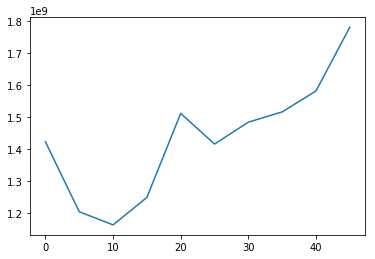

In [134]:
res = []
for n_leaves in range(1, 50, 5):
    cls = tree.DecisionTreeRegressor(min_samples_leaf=n_leaves)
    cls.fit(train_data_1, train_label)
    predicted_label = cls.predict(dev_data_1)
    res.append(mean_squared_error(predicted_label, dev_label))
    
print("optimal value: ", np.min(res))
plt.plot(np.arange(len(res)) * 5, res)

# 1.2 Selecting alternative models.

optimal value:  1384667632.2838001


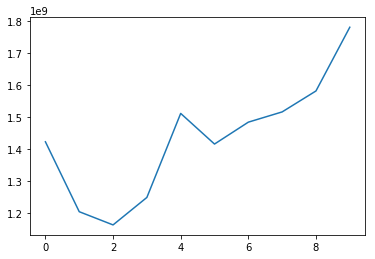

In [144]:
from sklearn.linear_model import Lasso

res_lr = []
for alpha in np.logspace(-1, 2, 10):
    lr = Lasso(alpha=alpha)
    lr.fit(train_data_1, train_label)
    predicted_label = lr.predict(dev_data_1)
    res_lr.append(mean_squared_error(predicted_label, dev_label))

print("optimal value: ", np.min(res_lr))
plt.plot(np.arange(len(res_lr)), res)


In [ ]:
2.